# Taller T8 I-2022

<table align='left'>
<tr>
<td><img src='https://norbertbiedrzycki.pl/wp-content/uploads/2020/03/AI-legal-regulations-Norbert-Biedrzycki-blog-3.jpg' width='750'/></td>
</tr>
</table>


|      Nombre       |     ROL     | 
|-------------------|-------------|
| Sofía Riquelme    | 202073615-4 | 
| Vicente Ruiz      | 202073585-9 |
| Bayron Valenzuela | 202073580-8 | 


Los recientes progresos en inteligencia artificial están ampliando el impacto que esta tecnología puede tener en nuestras vidas. Con ello, la preocupación por los aspectos éticos detrás de las "decisiones" automáticas que estos sistemas implementan ha causado gran debate. Por ejemplo, desde hace algunos años, el sistema penal varios países ha comenzado a apoyarse en algoritmos "inteligentes" que predicen la probabilidad de reincidencia de un sujeto en base a una serie de atributos (como respuestas a un test). 

*¿Qué tan imparciales son estos algoritmos? ¿Reproducen los sesgos que observamos en el mundo humano? ¿Es necesario intervenir estas máquinas de modo que sus decisiones no se basen en atributos protegidos?*

En este taller aplicaremos conceptos del Tema 8 para analizar las predicciones de un algoritmo utilizado para predecir riesgo de reincidencia en algunos estados de Estados Unidos.


# Librerías

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

##############################################################

from scipy.stats import norm


# Datos

Los datos pueden ser descargados vía línea de comandos desde la dirección indicada abajo. 

In [ ]:
!wget www.inf.utfsm.cl/~jnancu/compas-scores-two-years.csv  -O compas-scores-two-years.csv

URL transformed to HTTPS due to an HSTS policy
--2022-07-20 23:32:55--  https://www.inf.utfsm.cl/~jnancu/compas-scores-two-years.csv
Resolving www.inf.utfsm.cl (www.inf.utfsm.cl)... 200.1.19.11, 2800:270:c::11
Connecting to www.inf.utfsm.cl (www.inf.utfsm.cl)|200.1.19.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546489 (2.4M) [application/octet-stream]
Saving to: ‘compas-scores-two-years.csv’

compas-scores-two-y 100%[===================>]   2.43M  2.31MB/s    in 1.1s    

2022-07-20 23:32:57 (2.31 MB/s) - ‘compas-scores-two-years.csv’ saved [2546489/2546489]



El dataset contiene información de una muestra de personas arrestadas en el condado de Broward (Florida) entre 2013 y 2014. Cada fila es un caso de arresto diferente. El algoritmo de interés se basa en las respuestas que una persona presenta a una serie de preguntas y está diseñado para predecir el *riesgo de reincidencia** en los 2 años posteriores a la liberación. Se han incluido en el dataset sólo casos de personas que, después de liberadas, fueron nuevamente condenadas durante los 2 años posteriores a su liberación, o bien de personas que no cometieron nuevos delitos durante los 2 años posteriores a su liberación. Siguiendo recomendaciones de los autores del dataset, se excluirán del análisis los casos en que el test para el algoritmo fue aplicado antes de 30 días de la fecha declarada del arresto (esto es un error) o después de 30 días de la fecha del arresto (caso muy inusual). También se excluirán casos de personas que fueron analizadas por el algoritmo.

Para facilitar las operaciones de filtrado, transformaremos el archivo csv en un dataframe de pandas.

In [ ]:
df = pd.read_csv('compas-scores-two-years.csv')
df = df[df['days_b_screening_arrest'] <= 30]
df = df[df['days_b_screening_arrest'] >= -30]
df = df[df['is_recid'] != -1]
print(len(df))

print(df.head())
print(df.columns)

6172
   id              name   first       last compas_screening_date   sex  \
0   1  miguel hernandez  miguel  hernandez            2013-08-14  Male   
1   3       kevon dixon   kevon      dixon            2013-01-27  Male   
2   4          ed philo      ed      philo            2013-04-14  Male   
5   7      marsha miles  marsha      miles            2013-11-30  Male   
6   8     edward riddle  edward     riddle            2014-02-19  Male   

          dob  age          age_cat              race  ...  v_decile_score  \
0  1947-04-18   69  Greater than 45             Other  ...               1   
1  1982-01-22   34          25 - 45  African-American  ...               1   
2  1991-05-14   24     Less than 25  African-American  ...               3   
5  1971-08-22   44          25 - 45             Other  ...               1   
6  1974-07-23   41          25 - 45         Caucasian  ...               2   

   v_score_text  v_screening_date  in_custody  out_custody  priors_count.1  \
0  

**Groundtruth.** La variable 'two_year_recid' indica si la persona efectivamente reincidió antes de 2 años de ser liberada ('two_year_recid'==1) o no ('two_year_recid'==0). La variable 'is_recid' indica si la persona reincidió antes del la fecha en que capturaron los datos. Puede ocurrir (200 casos) que una persona tenga 'two_year_recid'==0 pero 'is_recid'==1. 

**Predicción.** La predicción del algoritmo está disponible en dos escalas. La variable 'score_text' puede tomar tres valores: 'High', 'Medium', y 'Low' que corresponden a un riesgo de reincidencia alto, medio, y bajo, respectivamente. Estas predicciones serán tratadas como categóricas. La variable 'decile_score' toma valores de 1 a 10 que corresponden a los deciles de riesgo que predice el algoritmo: 1 significa que la persona está en el primer decil de riesgo, 2 que está en el segundo decil de riesgo, etc. Estas predicciones serán tratadas como numéricas. 

**Variables.** Además de la predicción del algoritmo, el dataset incluye una serie de atriubutos interesantes entre los que destacaremos: el sexo, edad y raza de la persona. El sexo ('sex') se encuentra en escala binaria ('Male', 'Female'). La edad se encuentra disponible en escala numérica ('age') y categórica ('age_cat'). En este último caso se usan tres niveles: '25 - 45' 'Greater than 45' 'Less than 25'. La raza ('race') es una variable categórica con valores posibles: 'Caucasian', 'African-American', 'Asian', 'Hispanic' , 'Native American', 'Other'.



# Mini Exploratorio

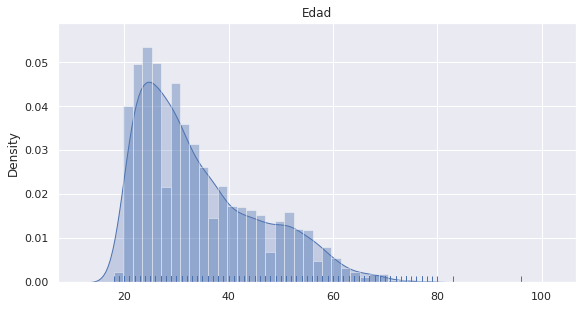

In [ ]:
f = plt.figure(figsize=(8,4))
ax = f.add_axes([0.1, 0.1, 0.9, 0.9])
sns.distplot(df['age'].values, ax=ax, rug=True, hist=True, kde_kws={"shade": True}, label = 'los angeles')
ax.set_title('Edad')
plt.show()

1: reincidente, 0: no reincidente


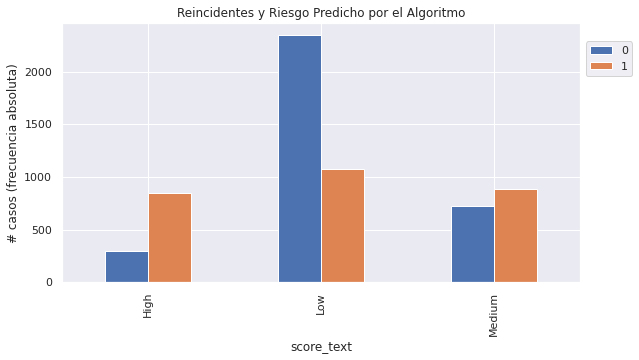

In [ ]:
print("1: reincidente, 0: no reincidente")

f = plt.figure(figsize=(8,4))
ax = f.add_axes([0.1, 0.1, 0.9, 0.9])
df.groupby('two_year_recid').score_text.value_counts().unstack(0).plot.bar(ax=ax)
ax.set_title('Reincidentes y Riesgo Predicho por el Algoritmo')
ax.set_ylabel('# casos (frecuencia absoluta)')
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.95))
plt.show()


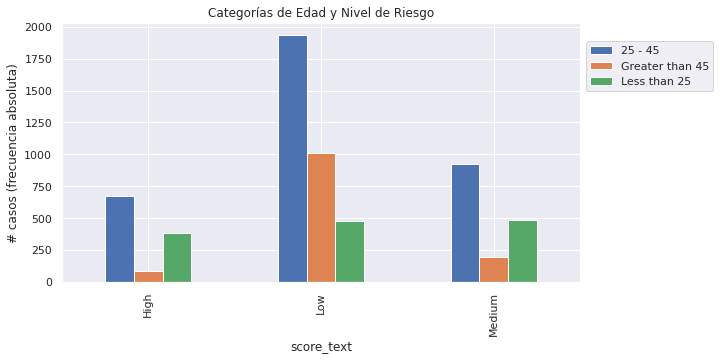

In [ ]:
f = plt.figure(figsize=(8,4))
ax = f.add_axes([0.1, 0.1, 0.9, 0.9])
df.groupby('age_cat').score_text.value_counts().unstack(0).plot.bar(ax=ax)
ax.set_title('Categorías de Edad y Nivel de Riesgo')
ax.set_ylabel('# casos (frecuencia absoluta)')
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.95))
plt.show()

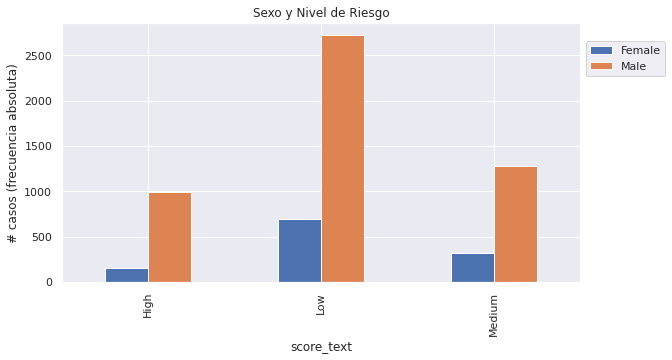

In [ ]:
f = plt.figure(figsize=(8,4))
ax = f.add_axes([0.1, 0.1, 0.9, 0.9])
df.groupby('sex').score_text.value_counts().unstack(0).plot.bar(ax=ax)
ax.set_title('Sexo y Nivel de Riesgo')
ax.set_ylabel('# casos (frecuencia absoluta)')
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.95))
plt.show()

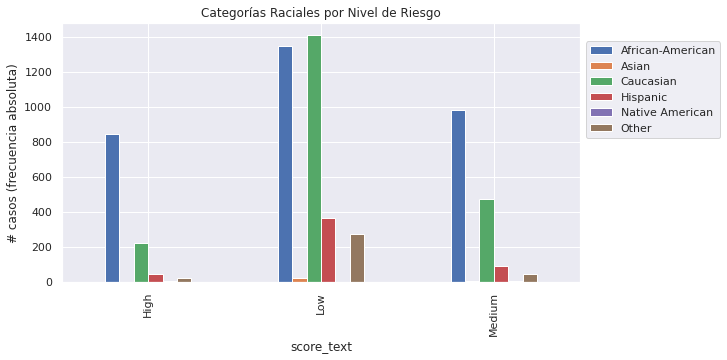

In [ ]:
f = plt.figure(figsize=(8,4))
ax = f.add_axes([0.1, 0.1, 0.9, 0.9])
df.groupby('race').score_text.value_counts().unstack(0).plot.bar(ax=ax)
ax.set_title('Categorías Raciales por Nivel de Riesgo')
ax.set_ylabel('# casos (frecuencia absoluta)')
ax.legend(loc='upper left', bbox_to_anchor=(1, 0.95))
plt.show()

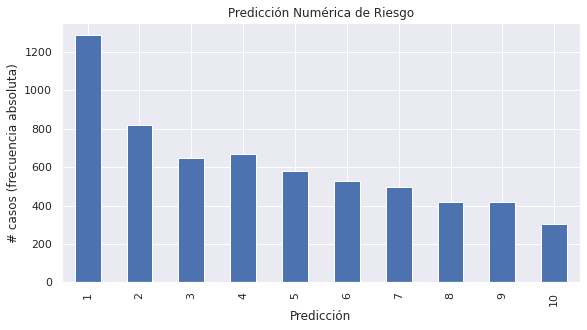

In [ ]:
f = plt.figure(figsize=(8,4))
ax = f.add_axes([0.1, 0.1, 0.9, 0.9])
df.groupby('decile_score').decile_score.value_counts().plot.bar(ax=ax)
ax.set_xticklabels([1,2,3,4,5,6,7,8,9,10])
ax.set_title('Predicción Numérica de Riesgo')
ax.set_xlabel('Predicción')
ax.set_ylabel('# casos (frecuencia absoluta)')

plt.show()

# Actividades

Un primer criterio para evaluar los eventuales "sesgos" (biases) de una IA consiste en determinar si selecciona algún atributo "protegido" de las personas como ***factor*** de decisión. En este taller, partiremos considerando el efecto de los factores raza, edad, y sexo en la decisión de la máquina de clasificar a una persona como de "alto riesgo de reincidencia". 

Otro criterio bastante común para evaluar el nivel de imparcialidad ("fairness") de una IA es comparar su ***eficacia*** en los diferentes grupos/segmentos de la población que se crean al considerar un atributo "protegido". En este taller, analizaremos el efecto de los factores raza, edad, y sexo, en los ***falsos positivos*** de la IA, es decir, la probabilidad de que la máquina haya clasificado una persona como de Alto Riesgo cuando en realidad la persona no reincidió después de ser liberada ('two_year_recid' != 1). 

Cierre esta sección comentando porqué podría ser inadecuado conducir el análisis condicionando al factor bajo estudio (e.g. raza) para luego comparar la proporción de personas de ese grupo que la IA clasifica como de alto riesgo con la proporción de personas que la IA clasifica como de bajo riesgo. 

In [ ]:
my_alpha=0.01

df_alto_riesgo = df[df['score_text']=='High']
df_bajo_riesgo = df[df['score_text']=='Low']


## A) Raza, Edad, y Sexo en las Decisiones de la IA

1.   Diseñe un contraste que permita evaluar la hipótesis de que *la proporción de afroamericanos en P1 es mayor que la proporción de afroamericanos en P2*. Diseñe su contraste de manera que la probabilidad de aceptar incorrectamente esta conjetura es menor al 1%. Exponga con claridad la hipótesis, la región crítica, y la decisión que corresponde tomar. Justifique su elección de H1.

Las hipotesis a considerar son: 

*   H<sub>0</sub> : P1 = P2 
*   H<sub>1</sub> : P1 > P2

Como rechazar la hipotesis de P1 = P2 abre la discusion sobre sesgos en la IA en cuanto a un factor protegido, se toma la decision de asignar dicha igualdad a H<sub>0</sub>. Por otro lado H<sub>1</sub> modela la desigualdad deseada y ejempifica el sesgo que se quiere evitar. 

Mientras que el estadistico de contraste es:

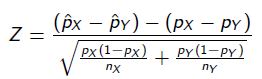

Para realizar un test sobre H<sub>0</sub>, este se asume verdadero. Ademas para que el error tipo 1 sea menor al 1% se considera una significancia del 0,01. Entonces la region critica es: 

*   Z<sub>0</sub> > Z<sub>0.01</sub> 




Donde Z<sub>0</sub> es Z asumiendo H<sub>0</sub> verdadero, es decir: \\
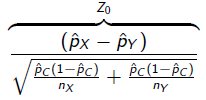
\
Notar que Z<sub>0.01</sub> es Z<sub>α</sub> con el valor adecuado de significacion 

In [ ]:
# Valor de Z tal que su significancia es 0.01
print(my_alpha)
norm.ppf(.99, 0, 1)

0.01


2.3263478740408408

In [ ]:
totalP1 = df_alto_riesgo.shape[0]
totalP2 = df_bajo_riesgo.shape[0]

cantidadAA_P1 = df_alto_riesgo['race'].value_counts()['African-American']
cantidadAA_P2 = df_bajo_riesgo['race'].value_counts()['African-American']

propAA_P1 = cantidadAA_P1/totalP1
propAA_P2 = cantidadAA_P2/totalP2

print("Para P1 al dividir las {} personas en el total poblacional de {} se obtiene la proporcion muestral para P1 {}".format(cantidadAA_P1,totalP1,propAA_P1))
print("Para P2 al dividir las {} personas en el total poblacional de {} se obtiene la proporcion muestral para P2 {}".format(cantidadAA_P2,totalP2,propAA_P2))


Para P1 al dividir las 845 personas en el total poblacional de 1144 se obtiene la proporcion muestral para P1 0.7386363636363636
Para P2 al dividir las 1346 personas en el total poblacional de 3421 se obtiene la proporcion muestral para P2 0.3934522069570301


Bajo H0 se asume que P1 = P2 entonces al calcular el estadistico se considera una proporcion del total de personas afroamericanas que en la muestra del total de P1 + P2

In [ ]:
propAA_Conjunta = (cantidadAA_P1+cantidadAA_P2) / (totalP1+totalP2)

Z_cero = (propAA_P1 - propAA_P2) / ( ( propAA_Conjunta*(1-propAA_Conjunta) * ( (1/cantidadAA_P1)+(1/cantidadAA_P2) ) ) ** 0.5 )

print(Z_cero > norm.ppf(.99, 0, 1))


True


Como el valor de Z<sub>0</sub> se encuentra en la región crítica se dice que hay evidencia suficiente como para rechazar H<sub>0</sub> con un nivel de significación de α = 0.01

2.   Diseñe un contraste que permita evaluar la hipótesis de que *la proporción de  mujeres en P1 es menor que la proporción de mujeres en P2*. Diseñe su contraste de manera que la probabilidad de aceptar incorrectamente esta conjetura es menor al 1%. Exponga con claridad la hipótesis, la región crítica, y la decisión que corresponde tomar. Justifique su elección de H1. 

Las hipotesis a considerar son: 

*   H<sub>0</sub> : P1 = P2 
*   H<sub>1</sub> : P1 < P2

Como rechazar la hipotesis de P1 = P2 abre la discusion sobre sesgos en la IA en cuanto a un factor protegido, se toma la decision de asignar dicha igualdad a H<sub>0</sub>. Por otro lado H<sub>1</sub> modela la desigualdad deseada y ejempifica el sesgo que se quiere evitar. 

Mientras que el estadistico de contraste es:

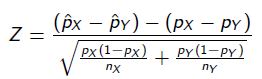

Para realizar un test sobre H<sub>0</sub>, este se asume verdadero. Ademas para que el error tipo 1 sea menor al 1% se considera una significancia del 0,01. Entonces la region critica es: 

*   Z<sub>0</sub> < Z<sub>0.99</sub> 




Donde Z<sub>0</sub> es Z asumiendo H<sub>0</sub> verdadero, es decir: \\
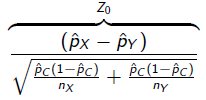
\
Notar que Z<sub>0.99</sub> es Z<sub>1-α</sub> con el valor adecuado de significacion 

In [ ]:
totalP1 = df_alto_riesgo.shape[0]
totalP2 = df_bajo_riesgo.shape[0]

cantidadM_P1 = df_alto_riesgo['sex'].value_counts()['Female']
cantidadM_P2 = df_bajo_riesgo['sex'].value_counts()['Female']

propM_P1 = cantidadM_P1/totalP1
propM_P2 = cantidadM_P2/totalP2

print("Para P1 al dividir las {} personas en el total poblacional de {} se obtiene la proporcion muestral para P1 {}".format(cantidadM_P1,totalP1,propM_P1))
print("Para P2 al dividir las {} personas en el total poblacional de {} se obtiene la proporcion muestral para P2 {}".format(cantidadM_P2,totalP2,propM_P2))

propM_Conjunta = (cantidadM_P1+cantidadM_P2) / (totalP1+totalP2)

Z_cero = (propM_P1 - propM_P2) / ( ( propM_Conjunta*(1-propM_Conjunta) * ( (1/cantidadM_P1)+(1/cantidadM_P2) ) ) ** 0.5 )

print(Z_cero < norm.ppf(.01, 0, 1))

Para P1 al dividir las 151 personas en el total poblacional de 1144 se obtiene la proporcion muestral para P1 0.131993006993007
Para P2 al dividir las 699 personas en el total poblacional de 3421 se obtiene la proporcion muestral para P2 0.20432622040339082
False


Como el valor de Z<sub>0</sub> no se encuentra en la region critica no hay evidencia suficiente para rechazar H<sub>0</sub> con un nivel de significacion de α = 0.01.

## B) Eficacia de la IA según Raza, Edad, y Sexo

Considere primero el nivel de riesgo numérico que el algoritmo asignó a la población de personas que se sabe que no-reincidieron (claramente, asignar un puntaje alto a estas personas es un error de la máquina). Queremos determinar si *existe evidencia para concluir que el puntaje medio que la máquina asigna a personas de algún grupo protegido es mayor que el puntaje medio que la máquina asigna a personas de un grupo de control*. 

1. Diseñe un contraste que permita determinar si el puntaje medio que la máquina asigna a personas afroamericanas no-reincidentes es mayor que el puntaje medio que la máquina asigna a personas de raza blanca no-reincidentes. Exponga con claridad sus hipótesis, indicando los criterios que utilizó para elegir H1 (favor lea bien el párrafo de más arriba). Indique la decisión que tomaría a partir del p-valor del contraste.

Como se estableció en el enunciado de la pregunta, lo que se quiere demostrar es si la máquina asigna a personas de algún grupo protegido (en este caso afroamericanos) es mayor que el puntaje medio que la máquina asigna a personas de algún grupo de control (en este caso personas de raza blanca). Por esta razón la hipótesis nula es que la máquina **no** asigna un puntaje mayor a los afroamericanos, es decir que les asigna un puntaje menor al puntaje asignado a las personas de raza blanca. Se formulan las hipótesis de esta manera dado que no genera polémica continuar aceptando la hipótesis nula, y es la que es más grave de rechazar incorrectamente. Si es que llamamos $A$ a el puntaje medio asignado a afroamericanos, y $C$ el puntaje medio asignado al grupo de control, las hipótesis del contraste queda de la siguiente manera:

* $H_0: A < C$

* $H_1: A \geq C$

Lo cual se puede analizar como:

* $H_0: A < C $

* $H_1: A = C$

Para el contraste, se asumirá H<sub>0</sub> como verdadera. Se aceptará una significancia de hasta 0.01 en el p-valor del contraste. Si es que es mayor a esto se concluye que no hay evidencia suficiene para rechazar H<sub>0</sub>. Se seguirá utilizando $\alpha=0.01.$

Entonces el estadístico de contraste corresponde a $Z_0 = \frac{(\overline{A} - \overline{C})}{\sqrt{\frac{\sigma_{A}^{2}}{n_A}}+\frac{\sigma_{C}^{2}}{n_C}}$

Se asume varianza conocida, correspondiente a la varianza de la muestra.

Asumiendo $H_0$ verdadera, la región crítica corresponde a $Z_0 > z_\alpha$

In [ ]:
print("\n ... Raza .... ")
df_afroamericanos = df[(df['race']=='African-American') & (df['two_year_recid']!=1)]#afroamericanos y no reincidentes
df_control = df[(df['race']=='Caucasian') & (df['two_year_recid']!=1)]#blancos y no reincidentes

total_afroamericanos = len(df_afroamericanos)
total_control = len(df_control)
#para ver el puntaje numérico asignado por la máquina, se convierte el valor de riesgo a número
df_afroamericanos['v_score_text'] = df_afroamericanos['v_score_text'].replace(['Low', 'Medium', 'High'], [0, 1, 2])
df_control['v_score_text'] = df_control['v_score_text'].replace(['Low', 'Medium', 'High'], [0, 1, 2])


#luego se obtienen los vaores medios de cada uno junto con las varianzas
media_afroamericanos = df_afroamericanos['v_score_text'].mean()
media_control = df_control['v_score_text'].mean()
varianza_afroamericanos = (df_afroamericanos['v_score_text'].std())**2
varianza_control = (df_control['v_score_text'].std())**2

Z_0 = (media_afroamericanos - media_control)/((varianza_afroamericanos/total_afroamericanos)+(varianza_control/total_control))**0.5
print("Estadístico de contraste dentro de la región crítica:")
print(Z_0 > norm.ppf(.99, 0, 1))


 ... Raza .... 
Estadístico de contraste dentro de la región crítica:
True


Con esto se concluye que sí hay suficiente evidencia para rechazar $H_0$, es decir, sí se le asigna un puntaje mayor a las personas afroamericanas no-reincidentes.


2. Diseñe un contraste que permita determinar si el puntaje medio que la máquina asigna a mujeres no-reincidentes es menor que el puntaje medio que la máquina asigna a hombres no-reincidentes. Exponga con claridad sus hipótesis, indicando los criterios que utilizó para elegir H1 (favor lea bien el párrafo inicial). Indique la decisión que tomaría a partir del p-valor del contraste.

Lo que se quiere determinar es si el puntaje medio asignado a mujeres no-reincidentes por la máquina es menor al puntaje asignado a hombres no-reincidentes. Sin embargo, como se establece en el párrafo inicial, el grupo protegido correspondería a las mujeres no-reincidentes y el grupo de control correspondería a los hombres no-reincidentes. Por esta razón, la hipótesis nula corresponde a que la máquina le asigna un puntaje menor a las mujeres no reincidentes, dado que esta hipótesis es grave de rechazar incorrectamente y es la aceptada actualmente. Si $M$ corresponde a el puntaje medio asignado por la máquina al grupo protegido, y $C$ corresponde al puntaje medio asignado por la máquina al grupo de control, las hipótesis quedan formuladas de la siguiente manera:
* $H_0: M < C $

* $H_1: M \geq C$

Lo cual se puede analizar como:

* $H_0: M < C$

* $H_1: M = C$

Asumiendo varianza conocida correspondiente a la varianza de la muestra, el estadístico de contraste corresponde a $Z_0 = \frac{(\overline{M} - \overline{C})}{\sqrt{\frac{\sigma_{M}^{2}}{n_M}}+\frac{\sigma_{C}^{2}}{n_C}}$

Luego, asumiendo que $H_0$ es verdadera, la región crítica corresponde a $Z_0 > z_\alpha$



In [ ]:
print("\n ... Sexo .... ")
df_mujeres = df[(df['sex']=='Female') & (df['two_year_recid']!=1)]
df_control = df[(df['sex']!='Female') & (df['two_year_recid']!=1)]

total_mujeres = len(df_mujeres)
total_control = len(df_control)
#para ver el puntaje numérico asignado por la máquina, se convierte el valor de riesgo a número
df_mujeres['v_score_text'] = df_mujeres['v_score_text'].replace(['Low', 'Medium', 'High'], [0, 1, 2])
df_control['v_score_text'] = df_control['v_score_text'].replace(['Low', 'Medium', 'High'], [0, 1, 2])


#luego se obtienen los vaores medios de cada uno junto con las varianzas
media_mujeres = df_mujeres['v_score_text'].mean()
media_control = df_control['v_score_text'].mean()
varianza_mujeres = (df_mujeres['v_score_text'].std())**2
varianza_control = (df_control['v_score_text'].std())**2

Z_0 = (media_mujeres - media_control)/((varianza_afroamericanos/total_mujeres)+(varianza_control/total_control))**0.5
print("Estadístico de contraste dentro de la región crítica:")
print(Z_0 > norm.ppf(.99, 0, 1))



 ... Sexo .... 
Estadístico de contraste dentro de la región crítica:
False


Con esto se concluye que no hay evidencia suficiente para rechazar $H_0$

3. Diseñe un contraste que permita determinar si el puntaje medio que la máquina asigna a personas menores de 25 años es mayor que el puntaje medio que la máquina asigna al resto de las personas. Exponga con claridad sus hipótesis, indicando los criterios que utilizó para elegir H1. Indique la decisión que tomaría a partir del p-valor del contraste.

Ahora el grupo protegido corresponde a las personas menores de 25 años, y el grupo de control al resto de la población, y se quiere determinar que el puntaje medio asignado al grupo portegido es mayor al puntaje medio asignado al grupo de control, razón por la que esta será la hipótesis alternativa. La hipótesis nula corresponderá a que el puntaje asignado al grupo protegido es **menor** que el puntaje medio asignado al grupo de control, dado que la hipótesis que es más grave rechazar incorrectamente. Siendo $J$ el puntaje medio asignado a las personas menores de 25 años y $C$ el puntaje medio asignado al resto de las personas, las hipótesis del contraste son las siguientes:

* $H_0: J < C $

* $H_1: J \geq C$

Lo cual se puede analizar como:

* $H_0: J < C$

* $H_1: J = C$

Asumiendo varianza conocida correspondiente a la varianza de la muestra, el estadístico de contraste corresponde a $Z_0 = \frac{(\overline{J} - \overline{C})}{\sqrt{\frac{\sigma_{J}^{2}}{n_J}}+\frac{\sigma_{C}^{2}}{n_C}}$

Luego, asumiendo que $H_0$ es verdadera, la región crítica corresponde a $Z_0 > z_\alpha$

In [ ]:
print("\n ... Edad .... ")
df_jovenes = df[(df['age_cat']=='Less than 25') & (df['two_year_recid']!=1)]#jovenes y no reincidentes
df_control = df[(df['age_cat']!='Less than 25') & (df['two_year_recid']!=1)]#no jovenes y no reincidentes

total_jovenes = len(df_jovenes)
total_control = len(df_control)
#para ver el puntaje numérico asignado por la máquina, se convierte el valor de riesgo a número
df_jovenes['v_score_text'] = df_jovenes['v_score_text'].replace(['Low', 'Medium', 'High'], [0, 1, 2])
df_control['v_score_text'] = df_control['v_score_text'].replace(['Low', 'Medium', 'High'], [0, 1, 2])


#luego se obtienen los vaores medios de cada uno junto con las varianzas
media_jovenes = df_jovenes['v_score_text'].mean()
media_control = df_control['v_score_text'].mean()
varianza_jovenes = (df_jovenes['v_score_text'].std())**2
varianza_control = (df_control['v_score_text'].std())**2

Z_0 = (media_jovenes - media_control)/((varianza_afroamericanos/total_jovenes)+(varianza_control/total_control))**0.5
print("Estadístico de contraste dentro de la región crítica:")
print(Z_0 > norm.ppf(.99, 0, 1))




 ... Edad .... 
Estadístico de contraste dentro de la región crítica:
True


Con esto se concluye que hay evidencia suficiente para rechazar $H_0$

Considere ahora la predicción discreta del algoritmo. Supongamos que medimos la eficacia del algoritmo usando la probabilidad de que arroje un ***falso positivo***, es decir, la probabilidad de que clasifique una persona como de Alto Riesgo pero que la persona no reincida ('two_year_recid' != 1).

4.   Para cada uno de los grupos protegidos considerados antes (jóvenes, mujeres, afroamericanos), diseñe un contraste que permita determinar si la proporción de falsos positivos es mayor en ese grupo respecto de su respectivo grupo de control. Indique la decisión que tomaría a partir del p-valor del contraste.

La decision final sobre cada contraste se decidira segun su p-valor. Se decide optar por mas holgura, aceptando una significancia de hasta  0.1 en su p-valor, de ser mayor a esto no se considerara suficiente la evidencia como para rechazar H<sub>0</sub>, es decir la igualdad de proporcion de falsos positivos en el grupo protegido con el de control.

En honor a la cohesion del informe se continuara realizando un analisis de contraste considerando una significancia α=0.01 ademas del analisis mencionado en el parrafo anterior. Esto permite tener una vision global del trabajo. 

In [ ]:
print("\n#### Predicciones Categóricas ####")
my_alpha = 0.01

####FALSOS POSITIVOS GLOBALES
n_FP = len(df.loc[(df['two_year_recid'] != 1) & (df['score_text'] == 'High'),['name']])
frac_FP = n_FP/len(df)
print("FFP", frac_FP )



#### Predicciones Categóricas ####
FFP 0.04812054439403759


In [ ]:
print("\n ... Raza .... ")
df_afroamericanos = df[df['race']=='African-American']
df_control_race = df[df['race']=='Caucasian']

n_FalsePos_afroamericanos = len(df_afroamericanos.loc[(df_afroamericanos['two_year_recid'] != 1) & (df_afroamericanos['score_text'] == 'High'),['name']])
n_FalsePos_control_race = len(df_control_race.loc[(df_control_race['two_year_recid'] != 1) & (df_control_race['score_text'] == 'High'),['name']])

################################################################################################

totalP1 = df_afroamericanos.shape[0]
totalP2 = df_control_race.shape[0]

prop_P1 = n_FalsePos_afroamericanos/totalP1
prop_P2 = n_FalsePos_control_race/totalP2

prop_Conjunta = (n_FalsePos_afroamericanos+n_FalsePos_control_race) / (totalP1+totalP2)

Z_cero = (prop_P1 - prop_P2) / ( ( prop_Conjunta*(1-prop_Conjunta) * ( (1/n_FalsePos_afroamericanos)+(1/n_FalsePos_control_race) ) ) ** 0.5 )

print("La premisa \'Existe evidencia para rechazar H0  con significancia 0.01\' es: {}".format(Z_cero > norm.ppf(1-my_alpha, 0, 1)))

# P valor, para que valor de alpha, norm.ppf va a ser igual a Z_cero
P_valor_afroamericanos = 1-norm.cdf(Z_cero)
print("P valor = {}".format(P_valor_afroamericanos))



 ... Raza .... 
La premisa 'Existe evidencia para rechazar H0  con significancia 0.01' es: False
P valor = 0.12195899071854455


Como se estipula inicialmente, dado que el p-valor muestra una significancia mayor a 0.1, no se considera problemas de sesgos en la IA respecto a esta variable protegida, es decir, no se considera evidencia suficiente para rechazar H<sub>0</sub>.

In [ ]:
print("\n ... Sexo .... ")
df_mujeres = df[df['sex']=='Female']
df_control_sex = df[df['sex']=='Male']
n_FalsePos_mujeres = len(df_mujeres.loc[(df_mujeres['two_year_recid'] != 1) & (df_mujeres['score_text'] == 'High'),['name']])
n_FalsePos_control_sex = len(df_control_sex.loc[(df_control_sex['two_year_recid'] != 1) & (df_control_sex['score_text'] == 'High'),['name']])

totalP1 = df_mujeres.shape[0]
totalP2 = df_control_sex.shape[0]

prop_P1 = n_FalsePos_mujeres/totalP1
prop_P2 = n_FalsePos_control_sex/totalP2

prop_Conjunta = (n_FalsePos_mujeres+n_FalsePos_control_sex) / (totalP1+totalP2)

Z_cero = (prop_P1 - prop_P2) / ( ( prop_Conjunta*(1-prop_Conjunta) * ( (1/n_FalsePos_mujeres)+(1/n_FalsePos_control_sex) ) ) ** 0.5 )

print("La premisa \'Existe evidencia para rechazar H0  con significancia 0.01\' es: {}".format(Z_cero > norm.ppf(1-my_alpha, 0, 1)))

# P valor, para que valor de alpha, norm.ppf va a ser igual a Z_cero
P_valor_mujeres = 1-norm.cdf(Z_cero)
print("P valor = {}".format(P_valor_mujeres))


 ... Sexo .... 
La premisa 'Existe evidencia para rechazar H0  con significancia 0.01' es: False
P valor = 0.5456918447450494


Dado que el p-valor muestra una significancia mayor a 0.1, no se consideran problemas de sesgos en la IA respecto a esta variable protegida, es decir, no se considera evidencia suficiente para rechazar H<sub>0</sub>.

In [ ]:
print("\n ... Edad .... ")
df_menores_25 = df[(df['age_cat']=='Less than 25')]
df_control_mayores = df[df['age_cat'].isin(['25 - 45','Greater than 45'])]
n_FalsePos_menores_25 = len(df_menores_25.loc[(df_menores_25['two_year_recid'] != 1) & (df_menores_25['score_text'] == 'High'),['name']])
n_FalsePos_control_mayores = len(df_control_mayores.loc[(df_control_mayores['two_year_recid'] != 1) & (df_control_mayores['score_text'] == 'High'),['name']])


totalP1 = df_menores_25.shape[0]
totalP2 = df_control_mayores.shape[0]

prop_P1 = n_FalsePos_menores_25/totalP1
prop_P2 = n_FalsePos_control_mayores/totalP2

prop_Conjunta = (n_FalsePos_menores_25+n_FalsePos_control_mayores) / (totalP1+totalP2)

Z_cero = (prop_P1 - prop_P2) / ( ( prop_Conjunta*(1-prop_Conjunta) * ( (1/n_FalsePos_menores_25)+(1/n_FalsePos_control_mayores) ) ) ** 0.5 )


print("La premisa \'Existe evidencia para rechazar H0  con significancia 0.01\' es: {}".format(Z_cero > norm.ppf(1-my_alpha, 0, 1)))

# P valor, para que valor de alpha, norm.ppf va a ser igual a Z_cero
P_valor_menores_25 = 1-norm.cdf(Z_cero)
print("P valor = {}".format(P_valor_menores_25))


 ... Edad .... 
La premisa 'Existe evidencia para rechazar H0  con significancia 0.01' es: False
P valor = 0.0709267073739861


Como su P-valor deja tolera una significancia maxima de alrededor de 0.07, considerando que esta es la que da paso a mayor seguridad de la relacion entre las proporciones, se considera la evidencia suficiente como para rechazar H<sub>0</sub>.